# SSN AB Test Results Analysis
### **LINK TO DECK: bit.ly/SSN_AB**

---

In [1]:
# Add Table of Contents

# %%javascript
# $('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
# $.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

In [2]:
# Python Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import rcParams
%matplotlib inline

style.use('seaborn-poster')
style.use('ggplot')

# Snowflake Import

from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL

url = URL (
    account = 'tq01613.us-east-1',
    user = 'ron.nahshon@lemonade.com',
    password = 'R0n1@lemonade',
    database = 'lemonade',
    schema = 'public',
    warehouse = 'compute_wh',
    role = 'analyst',
)

engine = create_engine(url)
connection = engine.connect()

In [3]:
# Import Test Results

query = """ 

WITH a AS
(
SELECT 
q.id AS quote_id,
p.id AS policy_id,
p.user_id,
q.form,
q.state,
q.created_at,
cr.id AS credit_id,
cr.score,
CASE WHEN q.tier >= 5 THEN '5+' WHEN q.tier < 5 THEN '<5' ELSE '0' END AS tier,
CASE WHEN q.answers:viewed_questions:"67" > 0 THEN TRUE ELSE FALSE END AS ssn_question_viewed,
ARRAY_CONTAINS('ssn'::VARIANT, PARSE_JSON(q.answers:answered)) AS ssn_question_answered,
q.data:ab_tests:"78" AS ab_test_value
    FROM quotes AS q
        LEFT JOIN credit_reports AS cr
        ON (q.user_id = cr.user_id
        OR q.id = cr.quote_id)
        LEFT JOIN policies AS p
        ON q.id = p.quote_id
            WHERE q.answers:viewed_questions:"67" IS NOT NULL
            AND q.created_at >= '2019-03-13'
            AND q.form IN ('ho3', 'ho6')
            AND q.state NOT IN  ('CA', 'MD')
            -- AND q.status NOT IN ('pending', 'uw_declined', 'stubbed')
            ORDER BY q.created_at ASC
)

-- select quote_id from a where credit_id is null;
-- credit score is null if status in 'pending', 'uw_declined', 'stubbed' or if the replacement costs are too high

SELECT 
ab_test_value,
COUNT(CASE WHEN ssn_question_viewed = TRUE THEN quote_id ELSE NULL END) AS ssn_viewed_q,
COUNT(CASE WHEN ssn_question_answered = TRUE THEN quote_id ELSE NULL END) AS ssn_answered_q,
-- COUNT(CASE WHEN credit_id IS NOT NULL THEN credit_id ELSE NULL END) AS num_with_credit_score,
COUNT(CASE WHEN score IS NOT NULL THEN score ELSE NULL END) AS num_with_credit_score_not_null,
ssn_viewed_q - COUNT(CASE WHEN credit_id IS NOT NULL THEN credit_id ELSE NULL END) AS num_without_credit_score,
COUNT(CASE WHEN credit_id IS NOT NULL AND score IS NULL THEN credit_id ELSE NULL END) AS num_with_credit_score_but_missing,
COUNT(CASE WHEN tier = '5+' THEN tier ELSE NULL END) AS num_tier_5_or_more,
COUNT(CASE WHEN tier = '<5' THEN tier ELSE NULL END) AS num_tier_under_5,
COUNT(CASE WHEN tier = '0' THEN tier ELSE NULL END) AS num_tier_null,
COUNT(CASE WHEN a.policy_id IS NOT NULL THEN a.policy_id ELSE NULL END) AS ssn_bought_policy,
ROUND(100.0 * num_with_credit_score_not_null / ssn_viewed_q, 2) AS pct_credit_score_not_null_viewed_q,
ROUND(100.0 * num_with_credit_score_not_null / COUNT(CASE WHEN credit_id IS NOT NULL THEN credit_id ELSE NULL END), 2) AS pct_credit_score_not_null_had_credit_score,
ROUND(100.0 * num_tier_5_or_more / ssn_viewed_q, 2) AS pct_users_tier_5_or_more,
ROUND(100.0 * ssn_answered_q / ssn_viewed_q, 2) AS pct_conv_answered,
ROUND(100.0 * ssn_bought_policy / ssn_viewed_q, 2) AS pct_conv_bought_policy
    FROM a
        WHERE ab_test_value IS NOT NULL
    GROUP BY 1
    ORDER BY 1;

"""

df = pd.read_sql(query, connection)
df.to_csv('ssn_ab_test_results.csv')

In [4]:
df = pd.read_csv('ssn_ab_test_results.csv', sep=',').drop('Unnamed: 0', axis=1)
df

,ab_test_value,ssn_viewed_q,ssn_answered_q,num_with_credit_score_not_null,num_without_credit_score,num_with_credit_score_but_missing,num_tier_5_or_more,num_tier_under_5,num_tier_null,ssn_bought_policy,pct_credit_score_not_null_viewed_q,pct_credit_score_not_null_had_credit_score,pct_users_tier_5_or_more,pct_conv_answered,pct_conv_bought_policy
0,"""1""",2047,1604,1372,572,103,887,623,537,71,67.02,93.02,43.33,78.36,3.47
1,"""2""",2002,1809,1456,356,190,1022,656,324,75,72.73,88.46,51.05,90.36,3.75


In [5]:
# Manipulate Dataset

cols = [c for c in df.columns if c.lower()[:3] != 'pct']
df_rev = df[cols]

df1 = df_rev.T.reset_index(drop=False)
df1 = df1.rename(columns={"index": "Funnel_Value", 0: "Nine_Digits", 1: "Four_Digits"})
df1 = df1.iloc[1:, ].reset_index(drop=True)
df1

,Funnel_Value,Nine_Digits,Four_Digits
0,ssn_viewed_q,2047,2002
1,ssn_answered_q,1604,1809
2,num_with_credit_score_not_null,1372,1456
3,num_without_credit_score,572,356
4,num_with_credit_score_but_missing,103,190
5,num_tier_5_or_more,887,1022
6,num_tier_under_5,623,656
7,num_tier_null,537,324
8,ssn_bought_policy,71,75


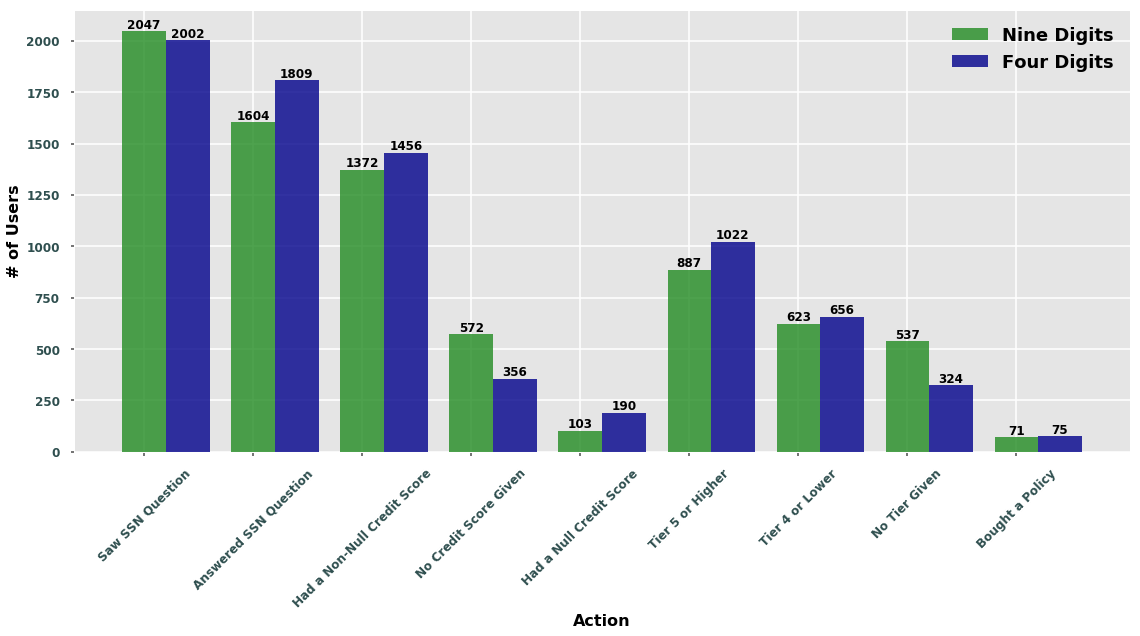

In [6]:
# Visualize Summary Results

plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

plt.figure(figsize=(16,9))

bar1 = plt.bar(np.arange(len(df1)), df1['Nine_Digits'], alpha=0.8, width=0.4, color='#228B22')
bar2 = plt.bar(np.arange(len(df1)) + 0.4, df1['Four_Digits'], alpha=0.8, width=0.4, color='darkblue')
# plt.title('SSN AB Test Results', fontsize=28, fontweight='bold', color='black')
plt.xlabel('Action', fontsize=16, fontweight='bold', color='black')
plt.ylabel('# of Users', fontsize=16, fontweight='bold', color='black')
x_ticks = ['Saw SSN Question', 'Answered SSN Question', 'Had a Non-Null Credit Score', 'No Credit Score Given', 'Had a Null Credit Score', 'Tier 5 or Higher', 'Tier 4 or Lower', 'No Tier Given', 'Bought a Policy']
plt.xticks(np.arange(len(df1)), x_ticks, rotation=45, fontsize=12, fontweight='bold', color='#2F4F4F')
plt.yticks(fontsize=12, fontweight='bold', color='#2F4F4F')
plt.legend(['Nine Digits', 'Four Digits'], loc='best', prop={'size': 18}, frameon=False)
rcParams['axes.titlepad'] = 15

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('SSN AB Test Results.png', bbox_inches='tight');

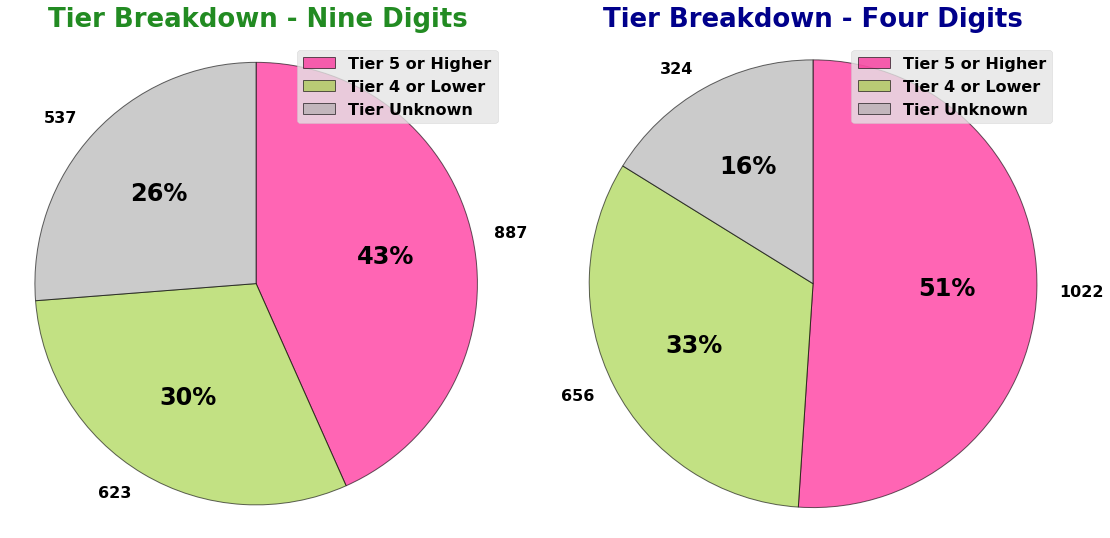

In [7]:
# Tier Pct Breakdowns

df_pie = df.copy()
df_pie['tier_5_or_more_pct'] = round(100.0 * df['num_tier_5_or_more'] / df['ssn_viewed_q'], 2)
df_pie['tier_under_5_pct'] = round(100.0 * df['num_tier_under_5'] / df['ssn_viewed_q'], 2)
df_pie['tier_not_known_pct'] = round(100.0 * df['num_tier_null'] / df['ssn_viewed_q'], 2)
df_pie = df_pie.T.iloc[-3:, ]

plt.rcParams['font.size'] = 24
colors = ['#FF0083', 'yellowgreen', 'darkgray']
def my_autopct(pct):
    return ('%.0f%%' % pct) if pct > 5.0 else ''

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.pie(df_pie[0], labels=df1.iloc[5:8, 1], autopct=my_autopct, startangle=90, counterclock=False, colors=colors, \
        wedgeprops={'edgecolor':'k', 'linewidth': 1, 'linestyle': '-', 'antialiased': True, 'alpha': 0.6})
plt.title('Tier Breakdown - Nine Digits', fontsize=26, fontweight='bold', color='#228B22')
plt.legend(labels=('Tier 5 or Higher', 'Tier 4 or Lower', 'Tier Unknown'), loc='best')
plt.axis('equal')

plt.subplot(1,2,2)
plt.pie(df_pie[1], labels=df1.iloc[5:8, 2], autopct=my_autopct, startangle=90, counterclock=False, colors=colors, \
        wedgeprops={'edgecolor':'k', 'linewidth': 1, 'linestyle': '-', 'antialiased': True, 'alpha': 0.6})
plt.title('Tier Breakdown - Four Digits', fontsize=26, fontweight='bold', color='darkblue')
plt.legend(['Tier 5 or Higher', 'Tier 4 or Lower', 'Tier Unknown'], loc='best')
plt.axis('equal')

plt.tight_layout()
plt.savefig('SSN AB Test Tier Breakdown.png', bbox_inches='tight');

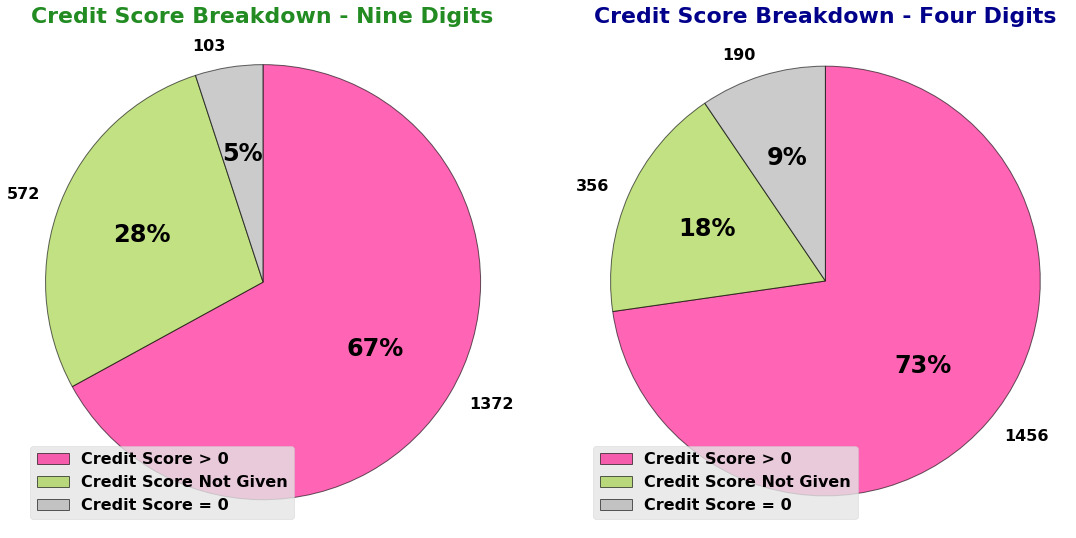

In [8]:
# Credit Score Pct Breakdowns

# Tier Pct Breakdowns

df_pie1 = df.copy()
df_pie1['had_credit_score_not_null_pct'] = round(100.0 * df['num_with_credit_score_not_null'] / df['ssn_viewed_q'], 2)
df_pie1['no_credit_score_pct'] = round(100.0 * df['num_without_credit_score'] / df['ssn_viewed_q'], 2)
df_pie1['had_credit_score_null_pct'] = round(100.0 * df['num_with_credit_score_but_missing'] / df['ssn_viewed_q'], 2)
df_pie1 = df_pie1.T.iloc[-3:, ]

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.pie(df_pie1[0], labels=df1.iloc[2:5, 1], autopct=my_autopct, startangle=90, counterclock=False, colors=colors, \
        wedgeprops={'edgecolor':'k', 'linewidth': 1, 'linestyle': '-', 'antialiased': True, 'alpha': 0.6})
plt.title('Credit Score Breakdown - Nine Digits', fontsize=22, fontweight='bold', color='#228B22')
plt.legend(['Credit Score > 0', 'Credit Score Not Given', 'Credit Score = 0'], loc='best')
plt.axis('equal')

plt.subplot(1,2,2)
plt.pie(df_pie1[1], labels=df1.iloc[2:5, 2], autopct=my_autopct, startangle=90, counterclock=False, colors=colors, \
        wedgeprops={'edgecolor':'k', 'linewidth': 1, 'linestyle': '-', 'antialiased': True, 'alpha': 0.6})
plt.title('Credit Score Breakdown - Four Digits', fontsize=22, fontweight='bold', color='darkblue')
plt.legend(['Credit Score > 0', 'Credit Score Not Given', 'Credit Score = 0'], loc='best')
plt.axis('equal')

plt.tight_layout()
plt.savefig('SSN AB Test Credit Score Breakdown.png', bbox_inches='tight');

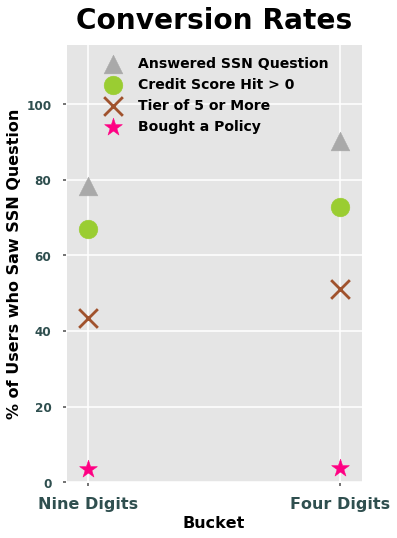

In [9]:
# % That Answered SSN Question

plt.figure(figsize=(6,8))

plt.scatter(df['ab_test_value'], df['pct_conv_answered'], marker='^', color=colors[2], s=350)
plt.scatter(df['ab_test_value'], df['pct_credit_score_not_null_viewed_q'], marker='o', color=colors[1], s=350)
plt.scatter(df['ab_test_value'], df['pct_users_tier_5_or_more'], marker='x', color='sienna', s=350)
plt.scatter(df['ab_test_value'], df['pct_conv_bought_policy'], marker='*', color=colors[0], s=350)
plt.title('Conversion Rates', fontsize=28, fontweight='bold', color='black')
plt.xlabel('Bucket', fontsize=16, fontweight='bold', color='black')
plt.ylabel('% of Users who Saw SSN Question', fontsize=16, fontweight='bold', color='black')
x_ticks = ['Nine Digits', 'Four Digits']
plt.xticks(np.arange(2), x_ticks, rotation=0, fontsize=16, fontweight='bold', color='#2F4F4F') # ('#228B22', 'darkblue')
plt.yticks(fontsize=12, fontweight='bold', color='#2F4F4F')
plt.legend(['Answered SSN Question', 'Credit Score Hit > 0', 'Tier of 5 or More', \
            'Bought a Policy'], loc='upper center', prop={'size': 14}, frameon=False)
plt.ylim(0,116)

plt.tight_layout()
plt.savefig('SSN AB Test Conversion Rates.png', bbox_inches='tight');

In [10]:
print(df.T)

                                                0      1
ab_test_value                                 "1"    "2"
ssn_viewed_q                                 2047   2002
ssn_answered_q                               1604   1809
num_with_credit_score_not_null               1372   1456
num_without_credit_score                      572    356
num_with_credit_score_but_missing             103    190
num_tier_5_or_more                            887   1022
num_tier_under_5                              623    656
num_tier_null                                 537    324
ssn_bought_policy                              71     75
pct_credit_score_not_null_viewed_q          67.02  72.73
pct_credit_score_not_null_had_credit_score  93.02  88.46
pct_users_tier_5_or_more                    43.33  51.05
pct_conv_answered                           78.36  90.36
pct_conv_bought_policy                       3.47   3.75


---